In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Read the Excel file into a pandas DataFrame
  df = pd.read_excel(io.BytesIO(uploaded[fn]))

# Display the first few rows of the DataFrame
display(df.head())

Saving Proc progress 2425.xlsx to Proc progress 2425 (1).xlsx
User uploaded file "Proc progress 2425 (1).xlsx" with length 94071 bytes


,Serial,PO Number,Contractor/ Firm,PO Issue Date,Items Demanded,Quantity Demanded,PO Amount (PKR),Items Delivered,Quantity Delivered,Number of Deliveries,Number of Rejection Events,Number of Days for Completion of Order
0,1,PO-24-25795,Lahore Motor Works,2024-11-19,5,1488,2194797,1,1274,1,3,17
1,2,PO-24-86820,Advance Auto Solutions,2025-01-19,9,674,289608,3,473,1,3,12
2,3,PO-24-16265,AlphaDrive Pakistan,2025-05-05,3,288,4791875,2,255,4,2,42
3,4,PO-24-47194,AlphaDrive Pakistan,2025-02-12,9,434,3712097,3,392,1,4,12
4,5,PO-24-54131,Quetta Auto Parts House,2025-05-30,6,1288,399115,2,1215,4,5,56


In [22]:
# Calculate summaries
total_firms = df['Contractor/ Firm'].nunique()
total_amount_allocated = df['PO Amount (PKR)'].sum()
total_items_demanded = df['Items Demanded'].sum()
total_quantity_demanded = df['Quantity Demanded'].sum()
total_items_delivered = df['Items Delivered'].sum()
total_quantities_delivered = df['Quantity Delivered'].sum()
total_bal_items = total_items_demanded - total_items_delivered
total_bal_quantities = total_quantity_demanded - total_quantities_delivered

# Create a DataFrame for the summary table
summary_data = {
    'Metric': [
        'Total Firms Participated',
        'Total Amount Allocated (PKR)',
        'Total Items Demanded',
        'Total Quantity Demanded',
        'Total Items Delivered',
        'Total Quantities Delivered',
        'Total Bal Items',
        'Total Bal Quantities'
    ],
    'Value': [
        total_firms,
        total_amount_allocated,
        total_items_demanded,
        total_quantity_demanded,
        total_items_delivered,
        total_quantities_delivered,
        total_bal_items,
        total_bal_quantities
    ]
}

summary_df = pd.DataFrame(summary_data)

# Display the summary table
display(summary_df)

,Metric,Value
0,Total Firms Participated,20
1,Total Amount Allocated (PKR),2514724708
2,Total Items Demanded,4998
3,Total Quantity Demanded,762691
4,Total Items Delivered,2958
5,Total Quantities Delivered,651414
6,Total Bal Items,2040
7,Total Bal Quantities,111277


# Task
Rank firms based on minimum balance quantity, minimum rejection events, and minimum days for completion of order, giving equal weightage to each factor, and display the ranking as a serialed list in descending order.

## Calculate metrics per firm

### Subtask:
Calculate the total balance quantity, total rejection events, and average days for completion of order for each firm.


**Reasoning**:
Calculate the balance quantity for each PO, then group by firm to get the sum of balance quantity, sum of rejection events, and average days for completion.



In [23]:
df['Balance Quantity'] = df['Quantity Demanded'] - df['Quantity Delivered']

firm_performance = df.groupby('Contractor/ Firm').agg(
    Total_Balance_Quantity=('Balance Quantity', 'sum'),
    Total_Rejection_Events=('Number of Rejection Events', 'sum'),
    Average_Days_for_Completion=('Number of Days for Completion of Order', 'mean')
).reset_index()

display(firm_performance.head())

,Contractor/ Firm,Total_Balance_Quantity,Total_Rejection_Events,Average_Days_for_Completion
0,Abbottabad Smart Motors,311,24,39.750000
1,Advance Auto Solutions,13693,295,39.403226
2,AlphaDrive Pakistan,14929,351,40.633803
3,DeltaTech Assemblers,3466,76,39.103448
4,Faisalabad Drive Systems,7630,168,40.243590


## Normalize the metrics

### Subtask:
Scale the calculated metrics so they can be compared and combined with equal weightage.


**Reasoning**:
Scale the relevant columns in `firm_performance` using MinMaxScaler to prepare for ranking.



In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

firm_performance[['Normalized_Balance_Quantity', 'Normalized_Rejection_Events', 'Normalized_Days_for_Completion']] = scaler.fit_transform(
    firm_performance[['Total_Balance_Quantity', 'Total_Rejection_Events', 'Average_Days_for_Completion']]
)

display(firm_performance.head())

,Contractor/ Firm,Total_Balance_Quantity,Total_Rejection_Events,Average_Days_for_Completion,Normalized_Balance_Quantity,Normalized_Rejection_Events,Normalized_Days_for_Completion
0,Abbottabad Smart Motors,311,24,39.750000,0.008200,0.038298,0.666667
1,Advance Auto Solutions,13693,295,39.403226,0.624712,0.614894,0.654337
2,AlphaDrive Pakistan,14929,351,40.633803,0.681655,0.734043,0.698091
3,DeltaTech Assemblers,3466,76,39.103448,0.153552,0.148936,0.643678
4,Faisalabad Drive Systems,7630,168,40.243590,0.345388,0.344681,0.684217


## Calculate a combined score

### Subtask:
Combine the normalized metrics to create a single ranking score for each firm.


**Reasoning**:
Combine the normalized metrics to create a single ranking score for each firm, where a higher score indicates better performance.



In [25]:
firm_performance['Ranking_Score'] = (1 - firm_performance['Normalized_Balance_Quantity']) + \
                                    (1 - firm_performance['Normalized_Rejection_Events']) + \
                                    (1 - firm_performance['Normalized_Days_for_Completion'])

display(firm_performance.head())

,Contractor/ Firm,Total_Balance_Quantity,Total_Rejection_Events,Average_Days_for_Completion,Normalized_Balance_Quantity,Normalized_Rejection_Events,Normalized_Days_for_Completion,Ranking_Score
0,Abbottabad Smart Motors,311,24,39.750000,0.008200,0.038298,0.666667,2.286835
1,Advance Auto Solutions,13693,295,39.403226,0.624712,0.614894,0.654337,1.106057
2,AlphaDrive Pakistan,14929,351,40.633803,0.681655,0.734043,0.698091,0.886212
3,DeltaTech Assemblers,3466,76,39.103448,0.153552,0.148936,0.643678,2.053834
4,Faisalabad Drive Systems,7630,168,40.243590,0.345388,0.344681,0.684217,1.625714


## Rank the firms

### Subtask:
Rank the firms based on the combined score in descending order.


**Reasoning**:
Sort the DataFrame by the ranking score in descending order and reset the index to create a new serial number.



In [26]:
firm_ranking = firm_performance.sort_values(by='Ranking_Score', ascending=False).reset_index(drop=True)
firm_ranking.index = firm_ranking.index + 1
firm_ranking = firm_ranking.rename_axis('Rank')
display(firm_ranking[['Contractor/ Firm', 'Ranking_Score']].head())

,Contractor/ Firm,Ranking_Score
Rank,,
1,Orbit Tech Industries,3.000000
2,Sialkot Precision Motors,2.515127
3,Islamabad Tech Supply Co.,2.450970
4,Pak Mechtronics Co.,2.352726
5,Mardan AutoElectrics,2.298315


## Display the ranking

### Subtask:
Present the ranked list of firms in a clear format.


**Reasoning**:
Select the specified columns from the firm_ranking dataframe and display them to show the final ranking.



In [28]:
# Display the ranking
display(firm_ranking[['Contractor/ Firm', 'Total_Balance_Quantity', 'Total_Rejection_Events', 'Average_Days_for_Completion', 'Ranking_Score']].head(3))

,Contractor/ Firm,Total_Balance_Quantity,Total_Rejection_Events,Average_Days_for_Completion,Ranking_Score
Rank,,,,,
1,Orbit Tech Industries,133,6,21.000000,3.000000
2,Sialkot Precision Motors,1044,27,32.200000,2.515127
3,Islamabad Tech Supply Co.,1153,21,34.222222,2.450970


/tmp/ipython-input-3021798327.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(firm_summary_viz['Contractor/ Firm'], rotation=90)


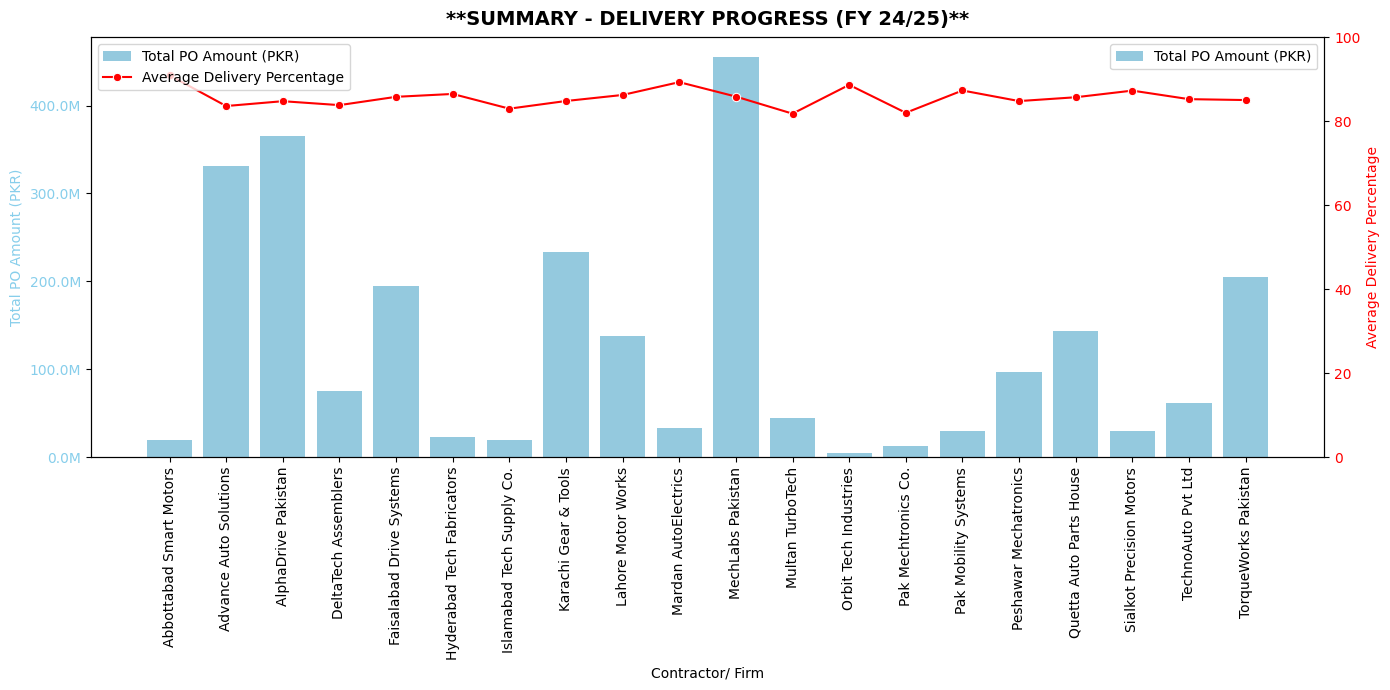

In [30]:
# Calculate delivery percentage per PO
df['Delivery Percentage'] = (df['Quantity Delivered'] / df['Quantity Demanded']) * 100

# Aggregate data by firm
firm_summary_viz = df.groupby('Contractor/ Firm').agg(
    Total_PO_Amount=('PO Amount (PKR)', 'sum'),
    Average_Delivery_Percentage=('Delivery Percentage', 'mean')
).reset_index()

# Create a combined plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Total PO Amount
sns.barplot(x='Contractor/ Firm', y='Total_PO_Amount', data=firm_summary_viz, ax=ax1, color='skyblue', label='Total PO Amount (PKR)')
ax1.set_ylabel('Total PO Amount (PKR)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(firm_summary_viz['Contractor/ Firm'], rotation=90)

# Format y-axis labels for PO Amount in millions
import matplotlib.ticker as mticker
formatter = mticker.FuncFormatter(lambda x, _: '{:.1f}M'.format(x/1e6))
ax1.yaxis.set_major_formatter(formatter)

# Create a second y-axis for Average Delivery Percentage
ax2 = ax1.twinx()
sns.lineplot(x='Contractor/ Firm', y='Average_Delivery_Percentage', data=firm_summary_viz, ax=ax2, color='red', marker='o', label='Average Delivery Percentage')
ax2.set_ylabel('Average Delivery Percentage', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 100) # Set y-axis limit for percentage

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('**SUMMARY - DELIVERY PROGRESS (FY 24/25)**', fontsize=14, fontweight='bold', ha='center', va='bottom')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The performance of each firm was assessed based on three metrics: total balance quantity, total rejection events, and average days for order completion.
*   These metrics were normalized using Min-Max scaling to ensure equal weightage in the ranking.
*   A combined ranking score was calculated for each firm by summing the inverted normalized metrics (1 - normalized metric), so that lower values for the original metrics result in a higher ranking score.
*   The firms were ranked in descending order based on this combined score.

### Insights or Next Steps

*   The ranking provides a clear view of firm performance across key operational efficiency indicators.
*   Further investigation could delve into the reasons behind high rejection events or long completion times for lower-ranked firms to identify areas for improvement.
